# Credit Score Simulator

## 💡 Business Problem

Many people don’t understand how their financial decisions affect their credit score, which can impact loan approvals, interest rates, and access to housing or employment. Credit scores are often seen as a “black box,” making financial education and planning difficult.

## 🎯 Business Objective

The goal of this project is to build a **credit score simulator** that helps users understand how different financial behaviors influence their creditworthiness. By training a **logistic regression model** on the German Credit dataset, we can interpret the feature weights and create a simple, transparent tool to simulate how actions like repaying debt, increasing income, or reducing credit utilization might affect a person’s score.

## 👥 Who Will It Impact?

- **Consumers** who want to make informed financial decisions.
- **Financial educators** aiming to explain credit scores in a simple way.
- **Lenders or credit counselors** interested in explaining risk in a more understandable format.

## 🔍 Approach

We will:
1. Preprocess the German Credit dataset
2. Train a logistic regression model
3. Analyze feature importance
4. Build a formula based on model weights
5. Simulate credit score changes based on user input

## ✅ Final Output

An interpretable score simulator based on real data that shows users the potential impact of their financial decisions.

## 🚀 Future Work

- Replace the logistic regression with more advanced models for improved accuracy.
- Create a web-based version (e.g., using Streamlit) for interactive simulation.
- Use local financial datasets or open banking APIs to personalize the tool to Canadian users.


## 🧹 Data Loading & Preprocessing

In this section, we load the **German Credit dataset** directly using the `ucimlrepo` package. This allows us to fetch both the feature set (`X`) and target labels (`y`) in a structured format.

### ✅ Steps:
- Load the dataset from UCI using `ucimlrepo`
- Rename generic columns to meaningful names for easier interpretation
- Map encoded categorical variables to human-readable labels

By the end of this section, the dataset will be clean and ready for exploratory analysis.


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 


{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

### 🔤 Rename Column Names

By default, the dataset's feature columns are labeled as `Attribute1`, `Attribute2`, ..., which are not descriptive and make the analysis harder to interpret.

As a first preprocessing step, we rename these columns using the official documentation from the [UCI German Credit Dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) to reflect the actual meaning of each feature.


In [3]:
X.columns

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20'],
      dtype='object')

In [4]:
column_names = [
    'Status_Checking_Account', 'Duration_Months', 'Credit_History', 'Purpose',
    'Credit_Amount', 'Savings_Account_Bonds', 'Employment_Since', 'Installment_Rate',
    'Personal_Status_Sex', 'Other_Debtors_Guarantors', 'Present_Residence_Since',
    'Property', 'Age', 'Other_Installment_Plans', 'Housing', 'Number_Credits',
    'Job', 'People_Liable', 'Telephone', 'Foreign_Worker'
]

X.columns = column_names

### 🔁 Mapping Encoded Categorical Variables

Many of the categorical variables in the German Credit dataset are encoded using codes like `'A11'`, `'A34'`, etc., which are not intuitive to interpret or analyze.

For example, before mapping, some of the column values looked like this:

In [5]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"{col}: {X[col].unique()}\n")


Status_Checking_Account: ['A11' 'A12' 'A14' 'A13']

Credit_History: ['A34' 'A32' 'A33' 'A30' 'A31']

Purpose: ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']

Savings_Account_Bonds: ['A65' 'A61' 'A63' 'A64' 'A62']

Employment_Since: ['A75' 'A73' 'A74' 'A71' 'A72']

Personal_Status_Sex: ['A93' 'A92' 'A91' 'A94']

Other_Debtors_Guarantors: ['A101' 'A103' 'A102']

Property: ['A121' 'A122' 'A124' 'A123']

Other_Installment_Plans: ['A143' 'A141' 'A142']

Housing: ['A152' 'A153' 'A151']

Job: ['A173' 'A172' 'A174' 'A171']

Telephone: ['A192' 'A191']

Foreign_Worker: ['A201' 'A202']



To improve interpretability, we created **mapping dictionaries** (based on the dataset documentation) to convert these codes into human-readable labels.


In [6]:
# Status of existing checking account
status_checking_account_map = {
    'A11': '< 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '>= 200 DM / salary assignment',
    'A14': 'no checking account'
}

# Credit history
credit_history_map = {
    'A30': 'no credits taken/ all paid',
    'A31': 'all credits paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account/ other credits existing'
}

# Purpose
purpose_map = {
    'A40': 'car (new)',
    'A41': 'car (used)',
    'A42': 'furniture/equipment',
    'A43': 'radio/TV',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A47': 'vacation',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

# Savings account/bonds
savings_account_map = {
    'A61': '< 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '>= 1000 DM',
    'A65': 'unknown/ no savings account'
}

# Present employment since
employment_since_map = {
    'A71': 'unemployed',
    'A72': '< 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '>= 7 years'
}

# Personal status and sex
personal_status_sex_map = {
    'A91': 'male : divorced/separated',
    'A92': 'female : divorced/separated/married',
    'A93': 'male : single',
    'A94': 'male : married/widowed',
    'A95': 'female : single'
}

# Other debtors / guarantors
other_debtors_map = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

# Property
property_map = {
    'A121': 'real estate',
    'A122': 'building society savings / life insurance',
    'A123': 'car or other',
    'A124': 'unknown / no property'
}

# Other installment plans
installment_plans_map = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

# Housing
housing_map = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

# Job
job_map = {
    'A171': 'unemployed/unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee/official',
    'A174': 'highly qualified/self-employed'
}

# Telephone
telephone_map = {
    'A191': 'none',
    'A192': 'yes, registered under the customer\'s name'
}

# Foreign worker
foreign_worker_map = {
    'A201': 'yes',
    'A202': 'no'
}


These mappings were applied to the dataset using `.map()` and `.loc[]` pandas functions.

In [7]:
X.loc[:, 'Status_Checking_Account'] = X['Status_Checking_Account'].map(status_checking_account_map)
X.loc[:, 'Credit_History'] = X['Credit_History'].map(credit_history_map)
X.loc[:, 'Purpose'] = X['Purpose'].map(purpose_map)
X.loc[:, 'Savings_Account_Bonds'] = X['Savings_Account_Bonds'].map(savings_account_map)
X.loc[:, 'Employment_Since'] = X['Employment_Since'].map(employment_since_map)
X.loc[:, 'Personal_Status_Sex'] = X['Personal_Status_Sex'].map(personal_status_sex_map)
X.loc[:, 'Other_Debtors_Guarantors'] = X['Other_Debtors_Guarantors'].map(other_debtors_map)
X.loc[:, 'Property'] = X['Property'].map(property_map)
X.loc[:, 'Other_Installment_Plans'] = X['Other_Installment_Plans'].map(installment_plans_map)
X.loc[:, 'Housing'] = X['Housing'].map(housing_map)
X.loc[:, 'Job'] = X['Job'].map(job_map)
X.loc[:, 'Telephone'] = X['Telephone'].map(telephone_map)
X.loc[:, 'Foreign_Worker'] = X['Foreign_Worker'].map(foreign_worker_map)



### 🧼 Data Quality Checks

Before diving deeper into the analysis, we check for missing values and duplicate rows to ensure data quality.

- **Missing values:** Can affect model performance and need to be handled appropriately.
- **Duplicate rows:** May bias the model if repeated records exist.


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Status_Checking_Account   1000 non-null   object
 1   Duration_Months           1000 non-null   int64 
 2   Credit_History            1000 non-null   object
 3   Purpose                   1000 non-null   object
 4   Credit_Amount             1000 non-null   int64 
 5   Savings_Account_Bonds     1000 non-null   object
 6   Employment_Since          1000 non-null   object
 7   Installment_Rate          1000 non-null   int64 
 8   Personal_Status_Sex       1000 non-null   object
 9   Other_Debtors_Guarantors  1000 non-null   object
 10  Present_Residence_Since   1000 non-null   int64 
 11  Property                  1000 non-null   object
 12  Age                       1000 non-null   int64 
 13  Other_Installment_Plans   1000 non-null   object
 14  Housing                  

In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB


In [10]:
# Check for duplicates
duplicates = X.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


Now, the dataset is ready for Exploratory Data Analysis (EDA).

In [11]:
X.head()

,Status_Checking_Account,Duration_Months,Credit_History,Purpose,Credit_Amount,Savings_Account_Bonds,Employment_Since,Installment_Rate,Personal_Status_Sex,Other_Debtors_Guarantors,Present_Residence_Since,Property,Age,Other_Installment_Plans,Housing,Number_Credits,Job,People_Liable,Telephone,Foreign_Worker
0,< 0 DM,6,critical account/ other credits existing,radio/TV,1169,unknown/ no savings account,>= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee/official,1,"yes, registered under the customer's name",yes
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee/official,1,none,yes
2,no checking account,12,critical account/ other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings / life insurance,45,none,for free,1,skilled employee/official,2,none,yes
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee/official,2,none,yes


### 🎯 Target Variable

The target variable is named `class` and indicates **credit risk**:

- `1` → Good credit risk  
- `2` → Bad credit risk  

For simplicity and consistency in modeling, we may later **convert this to a binary format**, where `1 = Good` and `0 = Bad`. However, for now, we'll explore it as is.


In [12]:
y

,class
0,1
1,2
2,1
3,1
4,2
...,...
995,1
996,1
997,1
998,2


## 📊 Exploratory Data Analysis (EDA)

The goal of this section is to understand the structure and distribution of the data, detect patterns, and identify potential relationships between the features and the target variable (`Credit Risk`).

We will explore:
- The distribution of the target variable
- Numerical features: summary statistics and visualizations
- Categorical features: value counts and bar charts
- Relationships between key features and credit risk


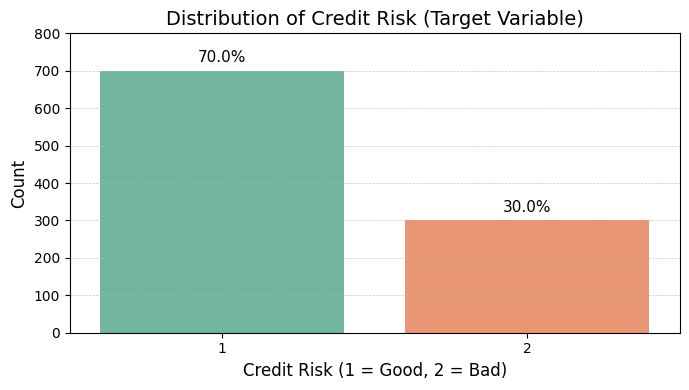

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy for plotting
y_plot = y.copy()
y_plot['proportion'] = y_plot['class'].map(y['class'].value_counts(normalize=True))

# Plot
plt.figure(figsize=(7, 4))
ax = sns.countplot(data=y_plot, x='class', hue='class', palette=['#66c2a5', '#fc8d62'], legend=False)

# Title and axis labels
plt.title('Distribution of Credit Risk (Target Variable)', fontsize=14)
plt.xlabel('Credit Risk (1 = Good, 2 = Bad)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Grid lines
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height / len(y) * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height + 15),  # slightly above the bar
                ha='center', va='bottom', fontsize=11)

# Add some vertical space to avoid cutting labels
plt.ylim(0, max(y['class'].value_counts()) + 100)

plt.tight_layout()
plt.show()

In [14]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration_Months,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
Credit_Amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Installment_Rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
Present_Residence_Since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Number_Credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
People_Liable,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


### 📊 Summary Statistics: Numerical Features

Below are the summary statistics for the main numerical variables in the dataset:

- `Duration_Months` ranges from 4 to 72 months, with a median of 18, showing most credit durations are short- to mid-term.
- `Credit_Amount` has a wide range, from 250 to 18,424. The mean is 3,271 but the high standard deviation suggests **potential outliers** or a right-skewed distribution.
- `Age` ranges from 19 to 75 years old, with a median age of 33. This indicates a fairly young customer base, but also with some older individuals included.
- Variables like `Installment_Rate`, `Present_Residence_Since`, `Number_Credits`, and `People_Liable` have lower ranges and standard deviations, indicating they are more stable and likely categorical or discrete numeric values.

These insights will help guide the next step, where we visualize the distributions of each numerical feature.


### 📈 Distribution of Numerical Features

We explore the distribution of the main numerical features to understand their central tendencies, skewness, and variability. This can help detect outliers and inform how we preprocess the data for modeling.


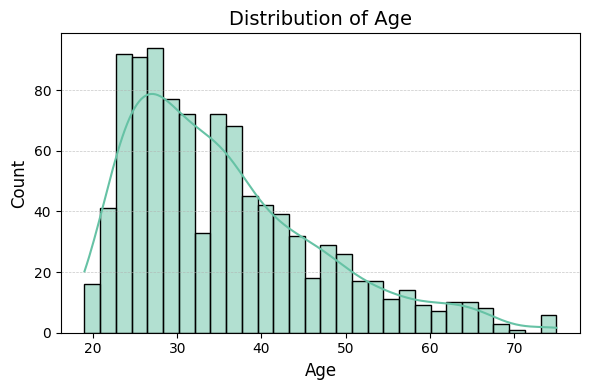

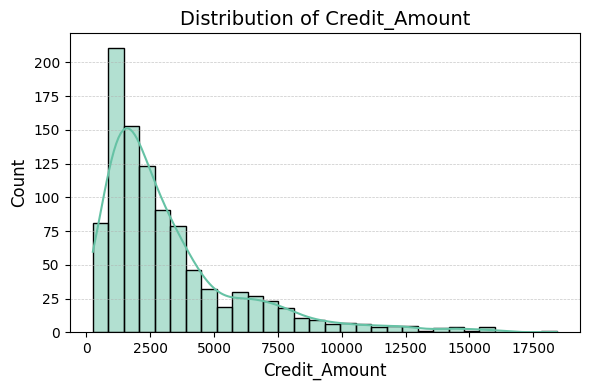

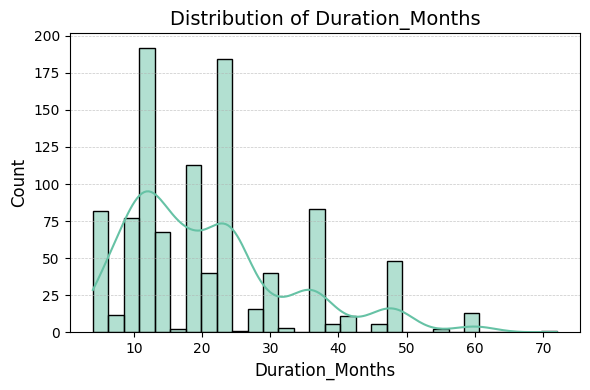

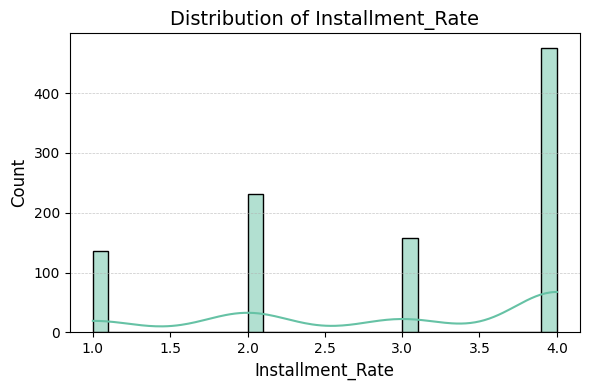

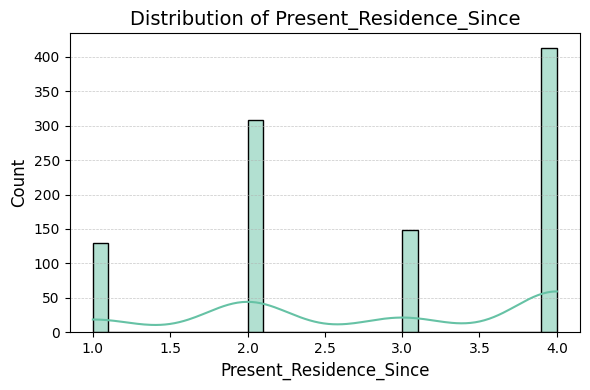

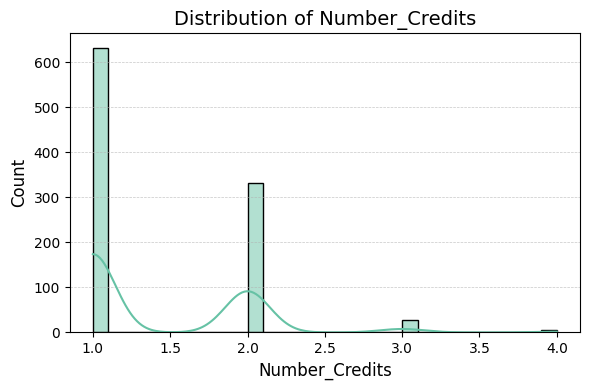

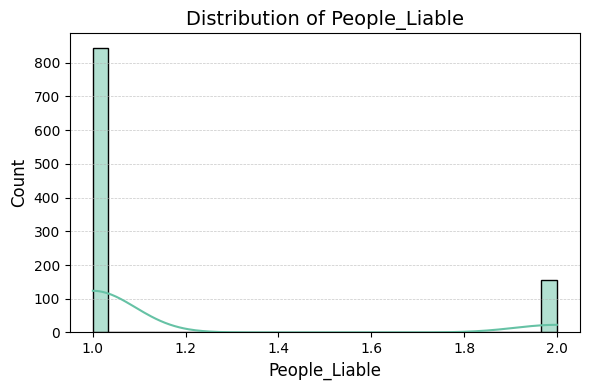

In [15]:
# List of selected numeric columns
num_cols = ['Age', 'Credit_Amount', 'Duration_Months', 
            'Installment_Rate', 'Present_Residence_Since', 
            'Number_Credits', 'People_Liable']

# Plot each histogram
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(X[col], kde=True, color='#66c2a5', bins=30)
    
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()



### 📉 Distribution of Numerical Features (Analysis)

Here’s a breakdown of the patterns observed from the histograms:

- **Age:** The distribution is right-skewed, with most customers between 25 and 40 years old. There are fewer older individuals, but some go up to 75.
  
- **Credit_Amount:** Strongly right-skewed with most values under 5,000. A few customers have extremely high credit amounts (over 15,000), indicating potential outliers.
  
- **Duration_Months:** Peaks are visible around 12, 18, and 24 months, suggesting common loan terms. Some longer durations exist but are less frequent.
  
- **Installment_Rate:** Only values from 1 to 4 are present, showing that this is a discrete variable. The value 4 is the most common.
  
- **Present_Residence_Since:** Values are from 1 to 4, possibly indicating years or categories. The most frequent is 4.
  
- **Number_Credits:** Majority of customers have either 1 or 2 credits, with very few having 3 or 4.
  
- **People_Liable:** Most customers are responsible for 1 person, with very few responsible for 2. This could be another indicator of financial stability.

These insights will help guide feature selection and engineering before modeling. In particular, features with strong skewness may benefit from transformation, while categorical-like numerics might be encoded differently.


### 🧪 Numerical Features vs. Credit Risk

To explore how numerical features relate to credit risk, we use boxplots. These visualizations help identify whether customers with bad credit risk (`class = 2`) tend to have higher or lower values for specific features, such as credit amount or loan duration.


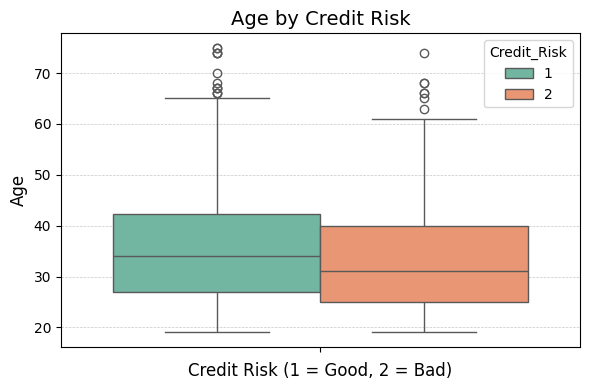

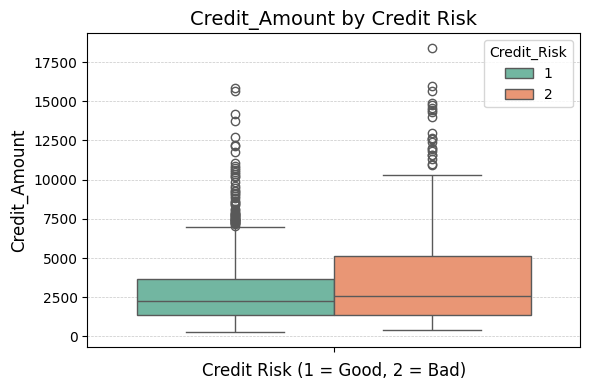

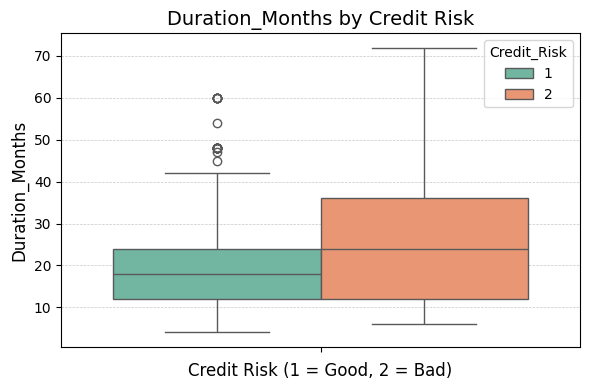

In [16]:
# Agregar la variable objetivo al dataset de features
X_box = X.copy()
X_box['Credit_Risk'] = y['class']

# Variables numéricas a analizar
num_cols = ['Age', 'Credit_Amount', 'Duration_Months']

# Boxplots para cada variable
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=X_box, hue='Credit_Risk', y=col, palette=['#66c2a5', '#fc8d62'])
    plt.title(f'{col} by Credit Risk', fontsize=14)
    plt.xlabel('Credit Risk (1 = Good, 2 = Bad)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()


#### 📌 Observations:

- **Credit Amount:** Customers with bad credit risk (`class = 2`) tend to have **higher credit amounts**, with more extreme outliers.
- **Duration Months:** Longer loan durations are also more common among bad credit risk customers.
- **Age:** There doesn’t appear to be a strong difference in age between good and bad credit risk customers, though there is slightly more spread in the good group.

These patterns may help the model distinguish between high and low-risk individuals based on financial behavior.


### 🗂️ Distribution of Categorical Features

Before comparing categorical features with credit risk, we analyze their overall distribution. This helps us understand which categories dominate each variable and if there’s class imbalance in the feature itself.


In [17]:
# Combine X with the target to create a complete dataset for EDA
X_cat = X.copy()
X_cat['Credit_Risk'] = y['class']


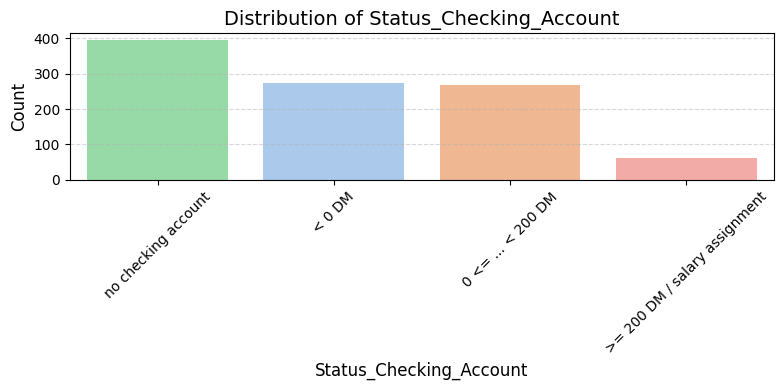

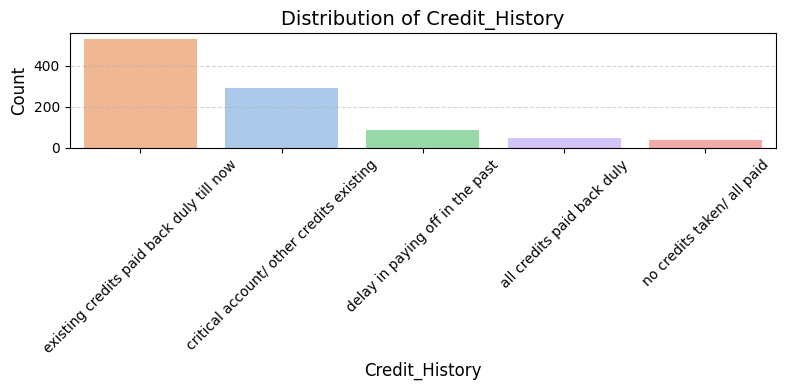

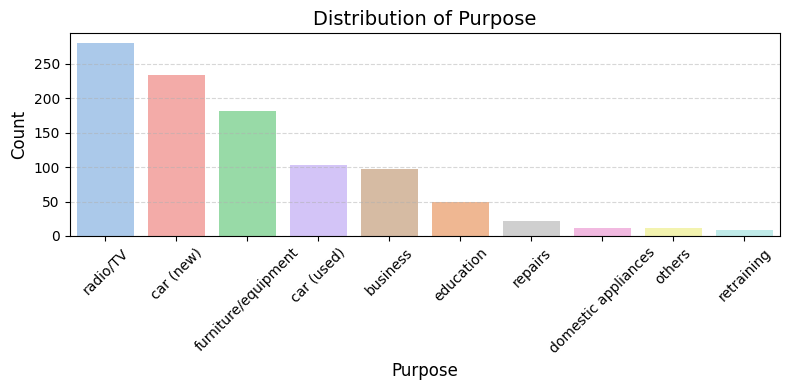

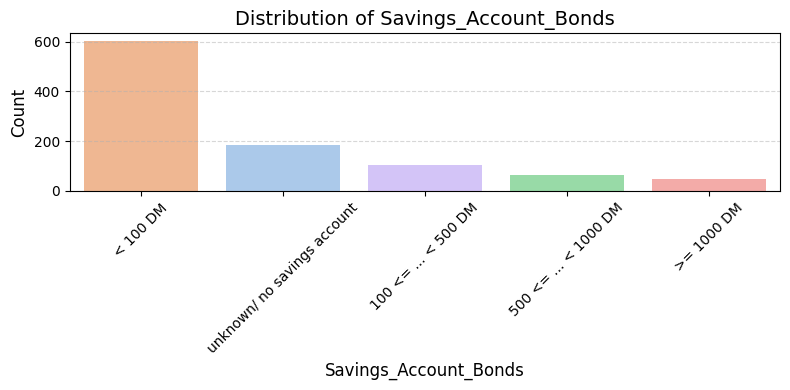

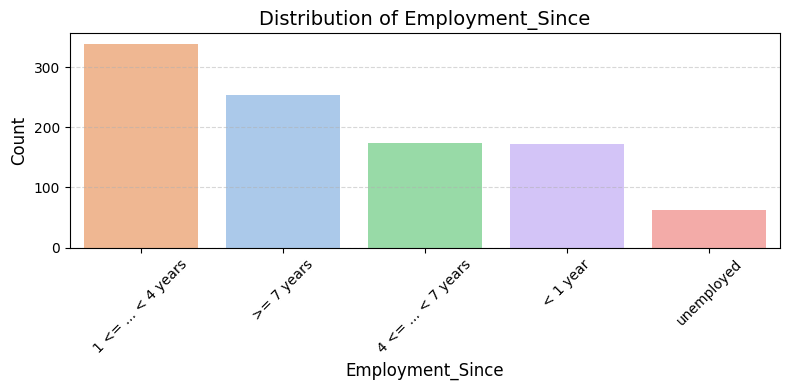

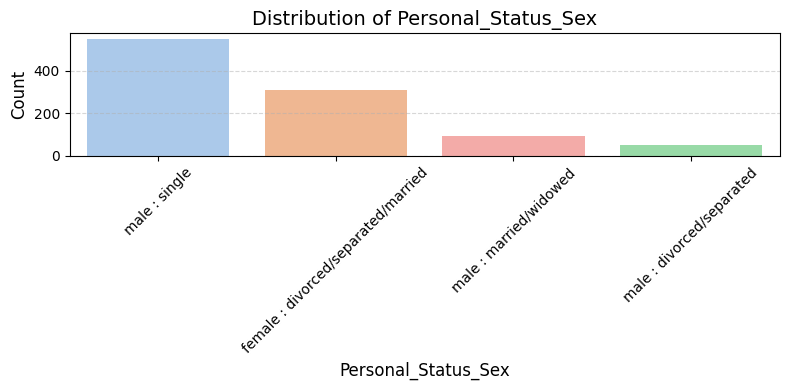

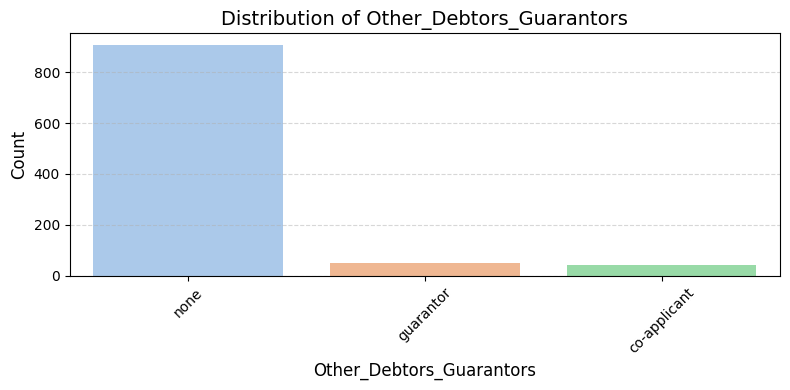

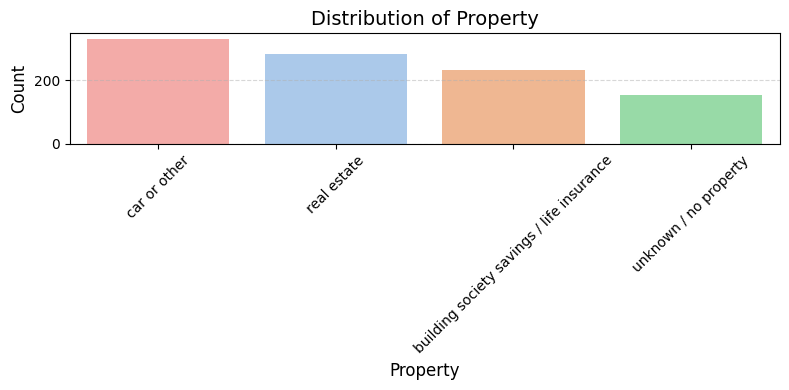

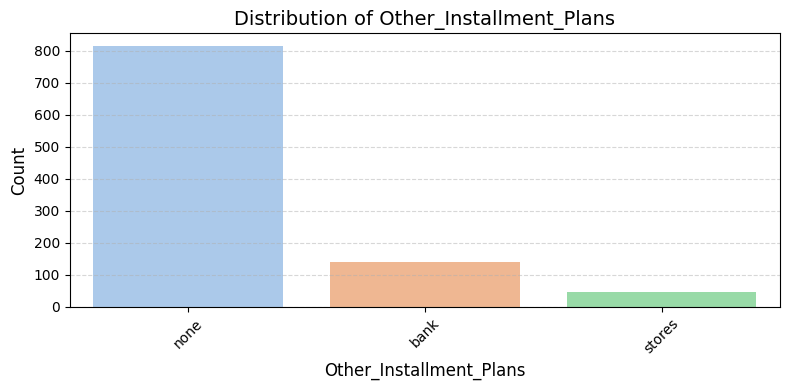

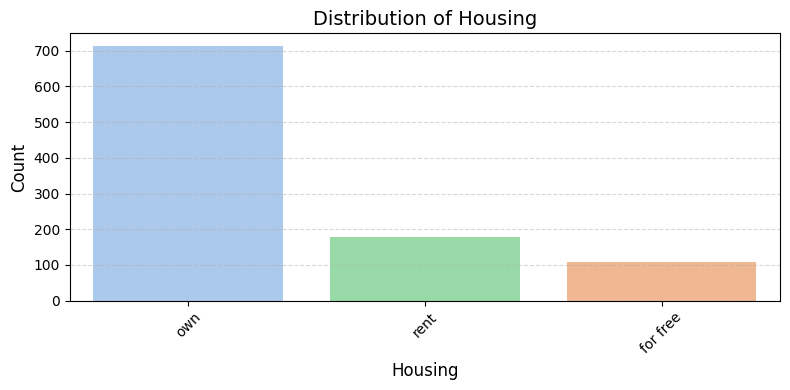

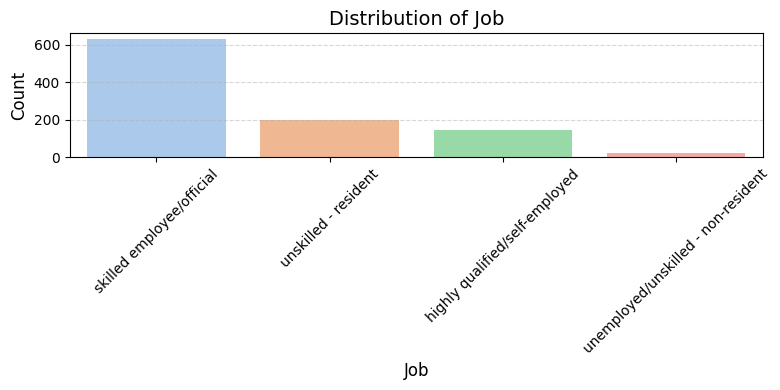

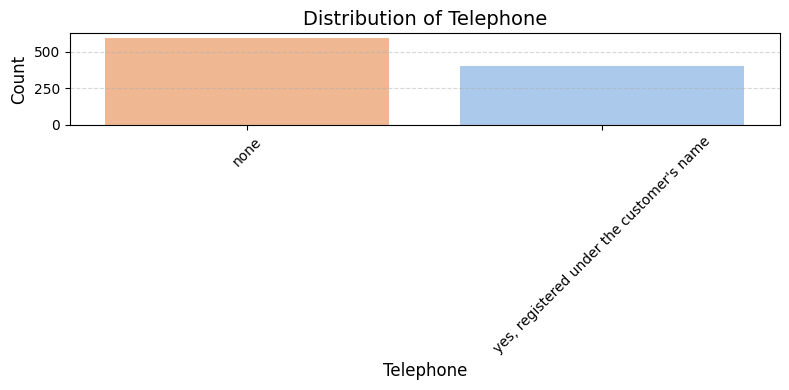

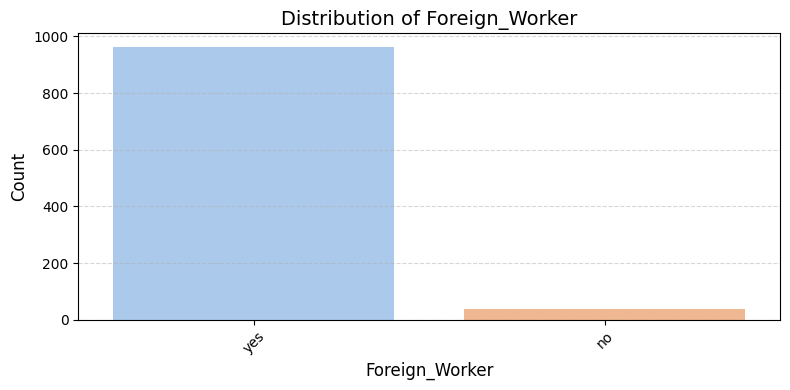

In [18]:
cat_cols = X.select_dtypes(include='object').columns

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=X_cat, x=col, hue=col, palette='pastel', order=X_cat[col].value_counts().index, legend=False)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### 🗂️ Distribution of Categorical Features

We analyzed the distribution of all categorical features in the dataset to understand the frequency of each category.

#### Key observations:
- **Status_Checking_Account:** Most customers either have no checking account or one with low balances.
- **Credit_History:** A large portion have a history of paying credits back duly, though many also have critical accounts.
- **Purpose:** Loans are most frequently taken for 'radio/TV' and 'car (new)', while others like 'repairs' or 'retraining' are rare.
- **Savings_Account_Bonds:** Most customers have savings under 100 DM or none at all.
- **Employment_Since:** The majority have been employed between 1 and 4 years; very few are unemployed.
- **Personal_Status_Sex:** Most are single males, followed by separated/divorced/married females.
- **Other_Debtors_Guarantors:** Most customers have no guarantor or co-applicant.
- **Property:** Fairly balanced between owning a car, real estate, or insurance; some have no property.
- **Other_Installment_Plans:** Most customers have no other installment plans.
- **Housing:** The majority own their homes, followed by renters.
- **Job:** Most customers are skilled employees or officials, with fewer unskilled or unemployed individuals.
- **Telephone:** Slightly more than half have no telephone registered under their name.
- **Foreign_Worker:** The vast majority are foreign workers, with very few marked as non-foreign.

These distributions help identify potential bias or dominance of certain categories before comparing them to the target variable.


### 📊 Categorical Features vs. Credit Risk (Proportional View)

To better understand how categorical variables relate to credit risk, we use normalized stacked bar charts. These charts show the **proportion of good vs. bad credit risk** within each category, making it easier to spot trends regardless of sample size.


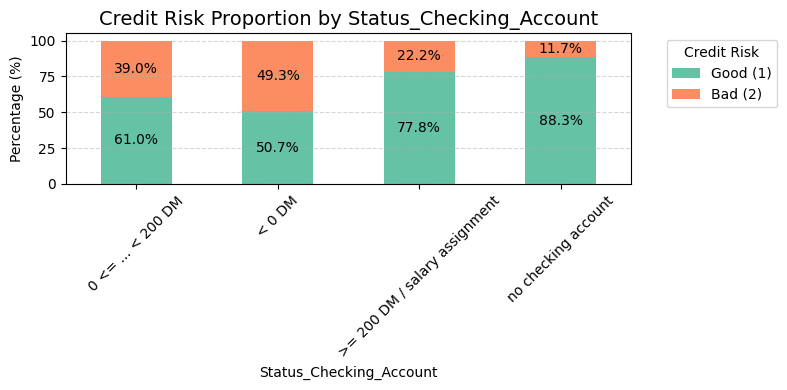

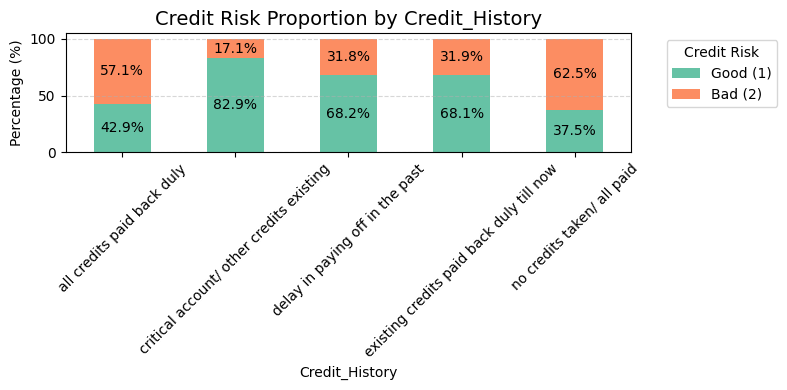

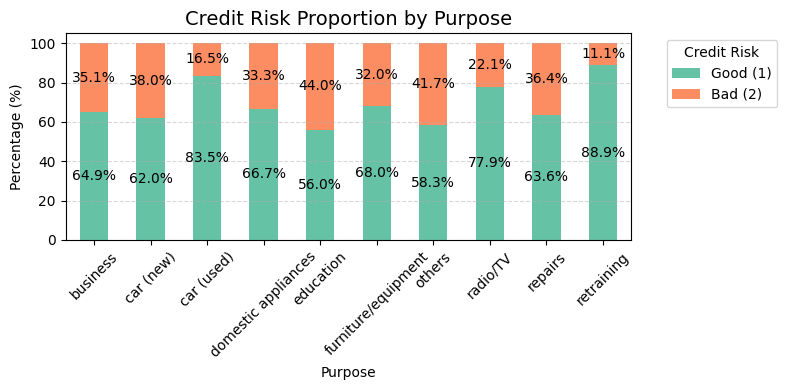

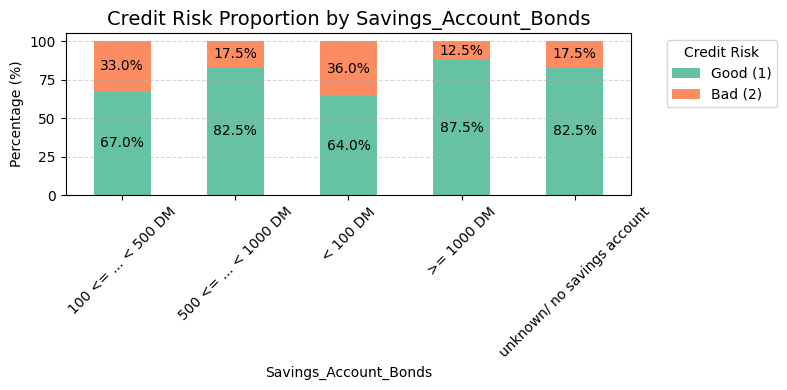

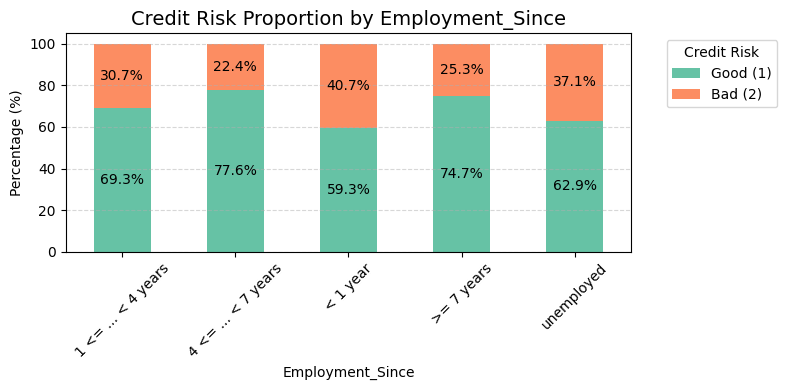

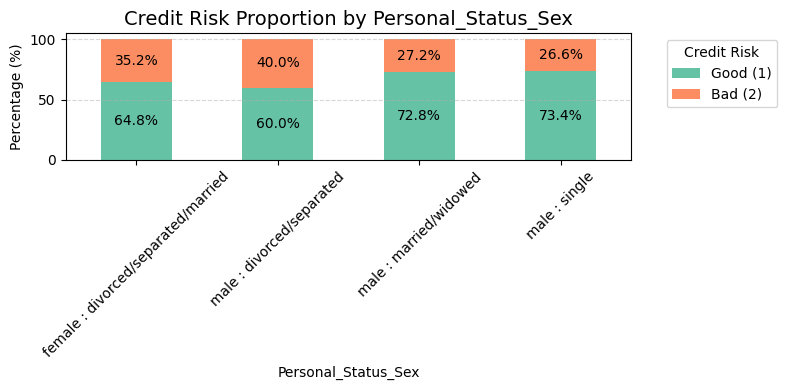

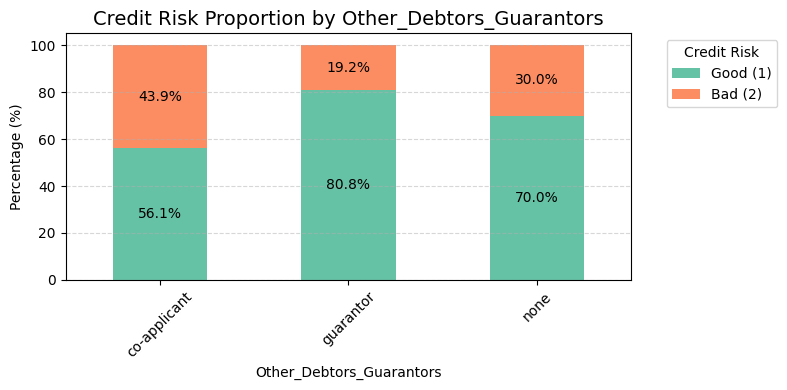

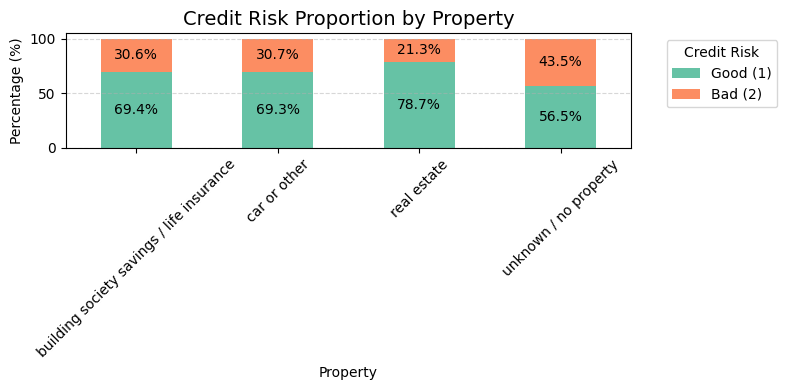

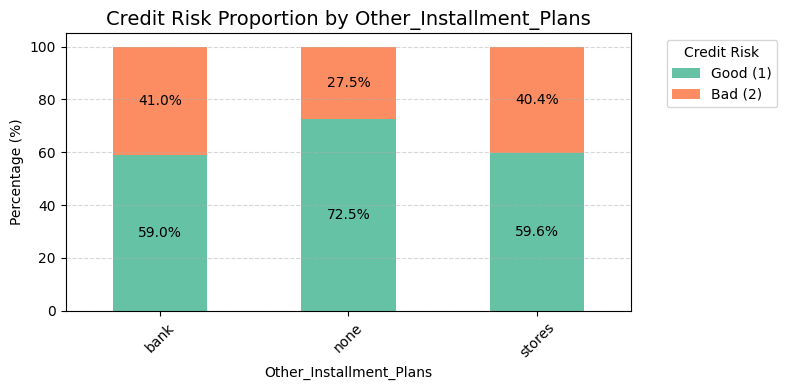

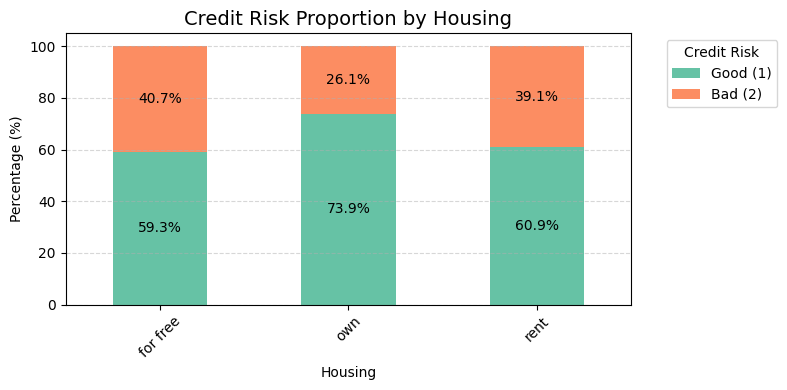

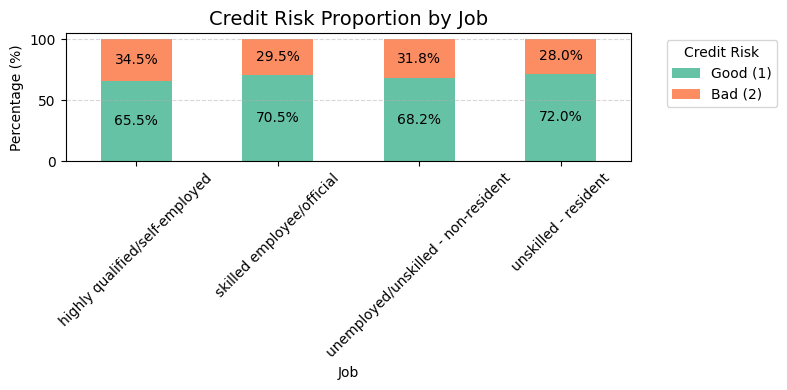

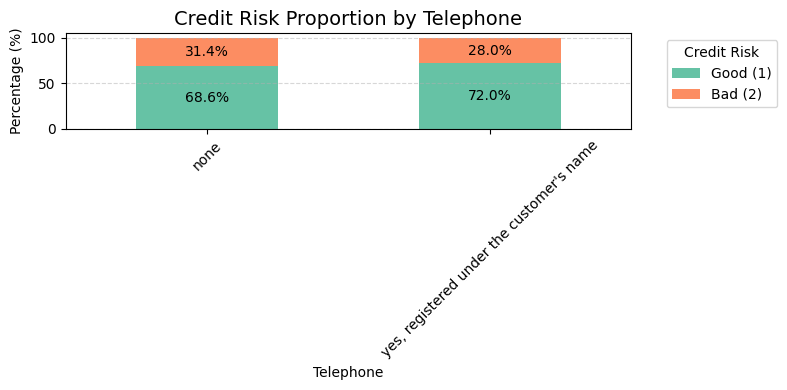

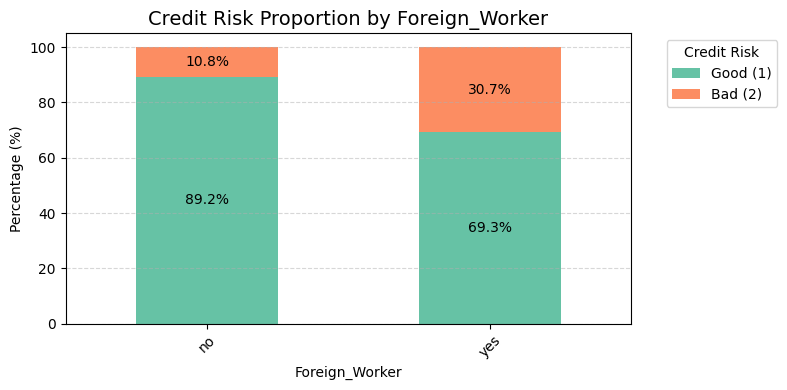

In [19]:
import pandas as pd

for col in cat_cols:
    ct = pd.crosstab(X_cat[col], X_cat['Credit_Risk'], normalize='index') * 100
    ax = ct.plot(kind='bar', stacked=True, figsize=(8, 4), color=['#66c2a5', '#fc8d62'])

    # Etiquetas de porcentaje dentro de las barras
    for container in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=10, color='black')

    plt.title(f'Credit Risk Proportion by {col}', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Mover la leyenda fuera del gráfico
    plt.legend(title='Credit Risk', labels=['Good (1)', 'Bad (2)'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### 🔍 Insights from Categorical Features vs. Credit Risk

By visualizing the proportion of good and bad credit risk within each category, we uncovered key patterns:

- **Status_Checking_Account:** Customers with no checking account show the highest percentage of good credit risk (88.3%). Those with lower balances have a noticeably higher risk.
- **Credit_History:** The category "critical account" is strongly associated with good credit (82.9%), while "all credits paid back duly" surprisingly has a higher proportion of bad credit (57.1%).
- **Purpose:** Categories like "retraining", "car (used)", and "radio/TV" show a higher share of good credit clients, while "education" and "domestic appliances" are riskier.
- **Savings_Account_Bonds:** Higher savings are associated with better credit risk. Customers with ≥ 1000 DM have 87.5% good credit.
- **Employment_Since:** Longer employment (> 4 years) correlates with lower risk, while those unemployed or with < 1 year are riskier.
- **Personal_Status_Sex:** Single males and married/widowed males show the lowest risk, while females and separated males are slightly riskier.
- **Other_Debtors_Guarantors:** Having a guarantor is associated with good credit. Co-applicants show higher bad credit rates.
- **Property:** Customers with real estate or insurance show lower risk, while those with no property are riskier.
- **Other_Installment_Plans:** Customers without other installment plans have slightly better credit risk.
- **Housing:** Owning a home is associated with better credit standing compared to renting or living for free.
- **Job:** Interestingly, unskilled residents have the highest proportion of good credit (72.0%), followed closely by skilled employees. Self-employed and unemployed groups are slightly riskier.
- **Telephone:** Customers with a registered phone in their name tend to have slightly better credit standing (72.0% good vs. 68.6%).
- **Foreign_Worker:** Surprisingly, customers classified as "not foreign workers" show the highest proportion of good credit risk (89.2%). However, this group is very small and may not be representative, so it should be interpreted with caution.


These relationships will help us decide which features might be most useful for the predictive model.


In [20]:
from sklearn.preprocessing import OneHotEncoder

# Variables categóricas verdaderas
true_cat_cols = X.select_dtypes(include='object').columns.tolist()

# Variables numéricas que parecen categóricas
num_like_cat = ['Installment_Rate', 'Present_Residence_Since', 'Number_Credits', 'People_Liable']

# Unimos ambas para codificar
final_cat_cols = true_cat_cols + num_like_cat

# Hacemos copia del dataset para evitar modificar el original
X_encoded = X.copy()

# Aplicamos One-Hot Encoding
X_encoded = pd.get_dummies(X_encoded, columns=final_cat_cols, drop_first=True)


In [21]:
X.head()

,Status_Checking_Account,Duration_Months,Credit_History,Purpose,Credit_Amount,Savings_Account_Bonds,Employment_Since,Installment_Rate,Personal_Status_Sex,Other_Debtors_Guarantors,Present_Residence_Since,Property,Age,Other_Installment_Plans,Housing,Number_Credits,Job,People_Liable,Telephone,Foreign_Worker
0,< 0 DM,6,critical account/ other credits existing,radio/TV,1169,unknown/ no savings account,>= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee/official,1,"yes, registered under the customer's name",yes
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee/official,1,none,yes
2,no checking account,12,critical account/ other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings / life insurance,45,none,for free,1,skilled employee/official,2,none,yes
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee/official,2,none,yes


In [22]:
X_encoded

,Duration_Months,Credit_Amount,Age,Status_Checking_Account_< 0 DM,Status_Checking_Account_>= 200 DM / salary assignment,Status_Checking_Account_no checking account,Credit_History_critical account/ other credits existing,Credit_History_delay in paying off in the past,Credit_History_existing credits paid back duly till now,Credit_History_no credits taken/ all paid,...,Installment_Rate_2,Installment_Rate_3,Installment_Rate_4,Present_Residence_Since_2,Present_Residence_Since_3,Present_Residence_Since_4,Number_Credits_2,Number_Credits_3,Number_Credits_4,People_Liable_2
0,6,1169,67,True,False,False,True,False,False,False,...,False,False,True,False,False,True,True,False,False,False
1,48,5951,22,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
2,12,2096,49,False,False,True,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,42,7882,45,True,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
4,24,4870,53,True,False,False,False,True,False,False,...,False,True,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,31,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
996,30,3857,40,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
997,12,804,38,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
998,45,1845,23,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


In [23]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las columnas numéricas reales
num_cols = ['Age', 'Credit_Amount', 'Duration_Months']

# Creamos una copia para escalar sin modificar el original
X_scaled = X_encoded.copy()

# Escalamos
scaler = StandardScaler()
X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])


In [24]:
X_scaled

,Duration_Months,Credit_Amount,Age,Status_Checking_Account_< 0 DM,Status_Checking_Account_>= 200 DM / salary assignment,Status_Checking_Account_no checking account,Credit_History_critical account/ other credits existing,Credit_History_delay in paying off in the past,Credit_History_existing credits paid back duly till now,Credit_History_no credits taken/ all paid,...,Installment_Rate_2,Installment_Rate_3,Installment_Rate_4,Present_Residence_Since_2,Present_Residence_Since_3,Present_Residence_Since_4,Number_Credits_2,Number_Credits_3,Number_Credits_4,People_Liable_2
0,-1.236478,-0.745131,2.766456,True,False,False,True,False,False,False,...,False,False,True,False,False,True,True,False,False,False
1,2.248194,0.949817,-1.191404,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
2,-0.738668,-0.416562,1.183312,False,False,True,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,1.750384,1.634247,0.831502,True,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
4,0.256953,0.566664,1.535122,True,False,False,False,True,False,False,...,False,True,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,-0.399832,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
996,0.754763,0.207612,0.391740,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
997,-0.738668,-0.874503,0.215835,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
998,1.999289,-0.505528,-1.103451,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


In [25]:
from sklearn.model_selection import train_test_split

# Cambiamos los valores de y a binarios: 1 = Good, 0 = Bad
y_bin = y['class'].map({1: 1, 2: 0})

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42, stratify=y_bin)


📋 Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        60
           1       0.78      0.81      0.79       140

    accuracy                           0.70       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.70      0.70      0.70       200



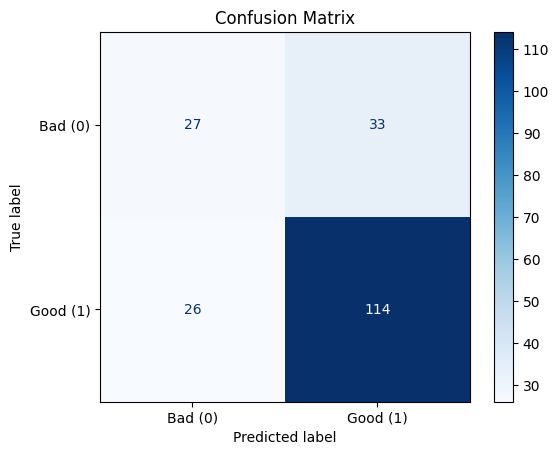

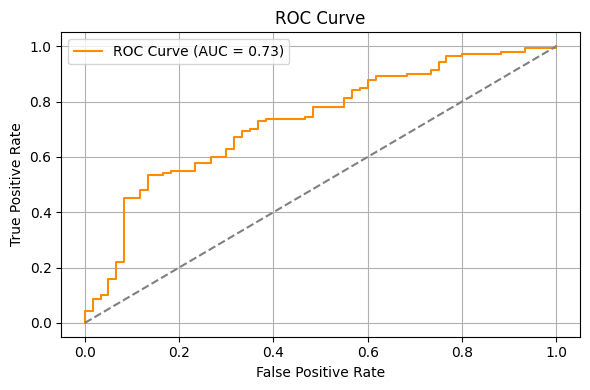

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Entrenamos el modelo
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predicciones
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# 1. Reporte de clasificación
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# 2. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad (0)", "Good (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\anaha\AppData\Local\Temp\ipykernel_23228\3345267725.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(15), x='Coefficient', y='Feature', palette='coolwarm')


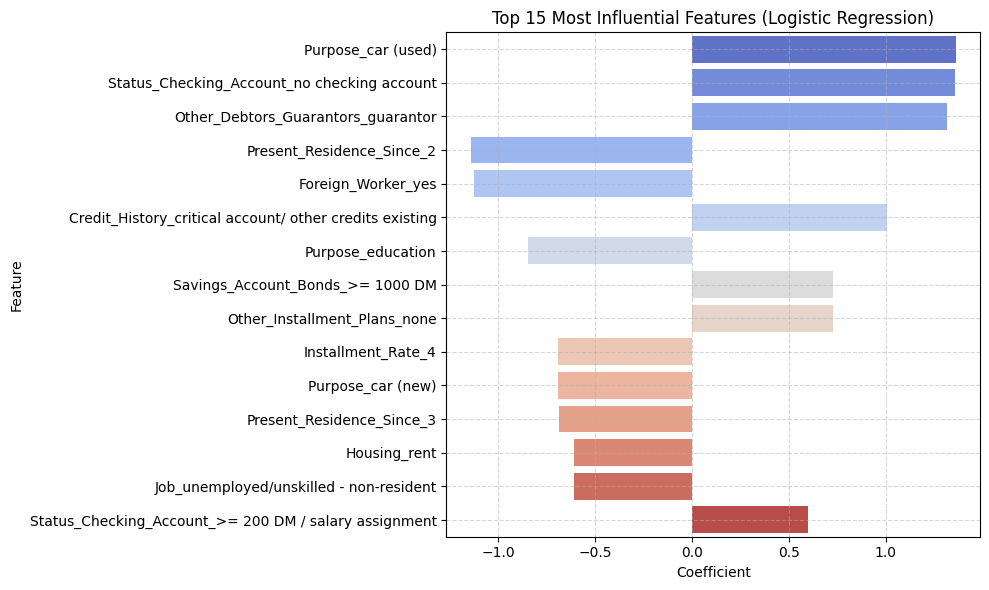

In [27]:
import numpy as np
import pandas as pd

# Extraemos los coeficientes y las columnas
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
})

# Ordenamos por valor absoluto del coeficiente
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Visualizamos los más relevantes
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(15), x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 15 Most Influential Features (Logistic Regression)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [28]:
final_features = X_scaled.columns.tolist()


In [29]:
def simulate_credit_score_custom(input_dict, model, scaler, feature_columns):
    import pandas as pd

    # Crear DataFrame base
    input_df = pd.DataFrame([0]*len(feature_columns), index=feature_columns).T

    # Escalar numéricas
    numeric_cols = ['Age', 'Credit_Amount', 'Duration_Months']
    numeric_input = pd.DataFrame([{c: input_dict.get(c, 0) for c in numeric_cols}])
    scaled_values = scaler.transform(numeric_input)

    for i, col in enumerate(numeric_cols):
        input_df[col] = scaled_values[0][i]

    # One-hot manual
    for col in feature_columns:
        for key, val in input_dict.items():
            if f"{key}_{val}" == col:
                input_df[col] = 1

    # Probabilidad
    prob = model.predict_proba(input_df)[0][1]

    # Conversion a score (rango 300–900)
    score = int(300 + (600 * prob))

    print(f"🔍 Probability of GOOD credit: {prob:.2%}")
    print(f"💳 Simulated Canadian Credit Score: {score}")
    
    return prob, score


In [30]:
example_input = {
    'Duration_Months': 24,
    'Credit_Amount': 5000,
    'Age': 35,
    'Status_Checking_Account': '< 0 DM',
    'Credit_History': 'critical account/other credits existing (not at this bank)',
    'Purpose': 'radio/TV',
    'Savings_Account_Bonds': '< 100 DM',
    'Employment_Since': '1 <= X < 4 years',
    'Personal_Status_Sex': 'male : single',
    'Other_Debtors_Guarantors': 'none',
    'Property': 'car or other',
    'Other_Installment_Plans': 'none',
    'Housing': 'own',
    'Job': 'skilled employee/official',
    'Telephone': 'yes, registered under the customer\'s name',
    'Foreign_Worker': 'yes'
}

simulate_credit_score_custom(example_input, log_reg, scaler, final_features)


🔍 Probability of GOOD credit: 81.79%
💳 Simulated Canadian Credit Score: 790


(0.8179113164319519, 790)

In [31]:
def plot_credit_score(score):
    import matplotlib.pyplot as plt

    # Score ranges and labels
    ranges = [300, 560, 660, 725, 760, 900]
    labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']

    # Determine score category
    category = ''
    for i in range(len(ranges) - 1):
        if ranges[i] <= score < ranges[i + 1]:
            category = labels[i]
            break
    else:
        category = labels[-1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 2))

    for i in range(len(ranges) - 1):
        ax.barh(0, ranges[i + 1] - ranges[i], left=ranges[i], color=colors[i], edgecolor='black', height=0.5)

    # Add the score marker
    ax.plot(score, 0, 'k^', markersize=15)
    ax.text(score, 0.35, f'{score}', ha='center', fontsize=12, fontweight='bold')

    # Aesthetics
    ax.set_xlim(300, 900)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.set_title('Simulated Canadian Credit Score', fontsize=14, fontweight='bold')

    # Add range labels
    for i in range(len(labels)):
        midpoint = (ranges[i] + ranges[i + 1]) / 2
        ax.text(midpoint, -0.55, labels[i], ha='center', fontsize=10)

    # Show the category message below the chart
    plt.figtext(0.5, -0.2, f"This score would be considered: {category}", ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()



🔍 Probability of GOOD credit: 81.79%
💳 Simulated Canadian Credit Score: 790


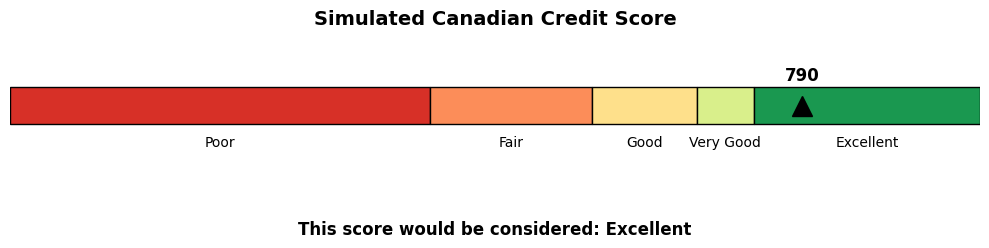

In [32]:
prob, score = simulate_credit_score_custom(example_input, log_reg, scaler, final_features)
plot_credit_score(score)


In [33]:
import os
import joblib

# Crear carpeta 'model' si no existe
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
model_path = os.path.join(model_dir, "log_reg_model.pkl")
joblib.dump(log_reg, model_path)

# Guardar scaler
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)

# Guardar columnas finales del dataset (después de get_dummies y escalado)
columns_path = os.path.join(model_dir, "feature_columns.pkl")
joblib.dump(X_train.columns.tolist(), columns_path)

print("✅ Model, scaler and feature columns successfully saved in /model folder.")


✅ Model, scaler and feature columns successfully saved in /model folder.


In [34]:
X_train.columns.tolist()

['Duration_Months',
 'Credit_Amount',
 'Age',
 'Status_Checking_Account_< 0 DM',
 'Status_Checking_Account_>= 200 DM / salary assignment',
 'Status_Checking_Account_no checking account',
 'Credit_History_critical account/ other credits existing',
 'Credit_History_delay in paying off in the past',
 'Credit_History_existing credits paid back duly till now',
 'Credit_History_no credits taken/ all paid',
 'Purpose_car (new)',
 'Purpose_car (used)',
 'Purpose_domestic appliances',
 'Purpose_education',
 'Purpose_furniture/equipment',
 'Purpose_others',
 'Purpose_radio/TV',
 'Purpose_repairs',
 'Purpose_retraining',
 'Savings_Account_Bonds_500 <= ... < 1000 DM',
 'Savings_Account_Bonds_< 100 DM',
 'Savings_Account_Bonds_>= 1000 DM',
 'Savings_Account_Bonds_unknown/ no savings account',
 'Employment_Since_4 <= ... < 7 years',
 'Employment_Since_< 1 year',
 'Employment_Since_>= 7 years',
 'Employment_Since_unemployed',
 'Personal_Status_Sex_male : divorced/separated',
 'Personal_Status_Sex_mal

In [36]:
# app.py
#import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Cargar modelo, scaler y columnas
model = joblib.load("model/log_reg_model.pkl")
scaler = joblib.load("model/scaler.pkl")
feature_columns = joblib.load("model/feature_columns.pkl")

In [40]:
X_scaled

,Duration_Months,Credit_Amount,Age,Status_Checking_Account_< 0 DM,Status_Checking_Account_>= 200 DM / salary assignment,Status_Checking_Account_no checking account,Credit_History_critical account/ other credits existing,Credit_History_delay in paying off in the past,Credit_History_existing credits paid back duly till now,Credit_History_no credits taken/ all paid,...,Installment_Rate_2,Installment_Rate_3,Installment_Rate_4,Present_Residence_Since_2,Present_Residence_Since_3,Present_Residence_Since_4,Number_Credits_2,Number_Credits_3,Number_Credits_4,People_Liable_2
0,-1.236478,-0.745131,2.766456,True,False,False,True,False,False,False,...,False,False,True,False,False,True,True,False,False,False
1,2.248194,0.949817,-1.191404,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
2,-0.738668,-0.416562,1.183312,False,False,True,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,1.750384,1.634247,0.831502,True,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,True
4,0.256953,0.566664,1.535122,True,False,False,False,True,False,False,...,False,True,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.738668,-0.544162,-0.399832,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
996,0.754763,0.207612,0.391740,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
997,-0.738668,-0.874503,0.215835,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
998,1.999289,-0.505528,-1.103451,True,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
